# Goal

The goal of this notebook is to use previously fitted/made dataset of sensors datasets, combine it with the generators dataset to predict an the amount of production at a given time with given Irradiations.

Same as before, 2nd plant's data will be used as testing data.

In [35]:
# Importing related datasets

import pandas as pd

# Import custom sensors' sets 
sens_df = pd.read_parquet("dataset/parquets/plant_1_updated_sensor")

# Import generator's sets
gen_df = pd.read_csv("dataset/Plant_1_Generation_Data.csv")

# Transforming datasets
from sklearn.cluster import KMeans

gen_df = gen_df.drop(columns=["SOURCE_KEY", "PLANT_ID", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"])
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='%d-%m-%Y %H:%M')

# sens_df = sens_df.drop(columns=["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE","time", "date"])
sens_df = sens_df.drop(columns=["time", "date"])

merge_df = gen_df.merge(sens_df, on="DATE_TIME")
merge_df = merge_df.drop(columns=["DATE_TIME"])

km = KMeans(n_clusters=3, max_iter=350, n_init=50)

merge_df['cluster'] = km.fit(merge_df[['time_id', 'IRRADIATION']]).labels_

test_sens_df = pd.read_parquet("dataset/parquets/plant_2_updated_sensor")

# Import generator's sets
test_gen_df = pd.read_csv("dataset/Plant_2_Generation_Data.csv")

# Transforming datasets

test_gen_df = test_gen_df.drop(columns=["SOURCE_KEY", "PLANT_ID", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"])
test_gen_df['DATE_TIME'] = pd.to_datetime(test_gen_df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# test_sens_df = test_sens_df.drop(columns=["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE","time", "date"])
test_sens_df = test_sens_df.drop(columns=["time", "date"])

test_merge_df = test_gen_df.merge(test_sens_df, on="DATE_TIME")
test_merge_df = test_merge_df.drop(columns=["DATE_TIME"])
test_km = KMeans(n_clusters=3, max_iter=350, n_init=50)

test_merge_df['cluster'] = test_km.fit(test_merge_df[['time_id', 'IRRADIATION']]).labels_

First issue: Need to merge both datasets but nb of rows not matching 
How to solve? We just need to transform our generation dataset with our values of irradiation and the time_id (at least), the rest are not really useful

Second issues: We have multiple modules on this datasets
How to solve? For this set and future testing (with Plant 2) including the source_key as input will only lead to imprecision.
If we wanted to predict on the same plant for future, we could keep the source key, which would give us more precision.
But given the way I'll test my models (As to see if close plants/set of modules can get predicted with close accuracy when trained on the other) 

In [16]:
# Preparing data into train/dev sets

from sklearn.model_selection import train_test_split

big_merged = test_merge_df.sample(frac=0.3)
big_merged = pd.concat([big_merged, merge_df])

X = big_merged
y = X.pop("AC_POWER")

X_test = test_merge_df
y_test = X_test.pop("AC_POWER")

x_train , x_dev , y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)


<Axes: xlabel='time_id', ylabel='IRRADIATION'>

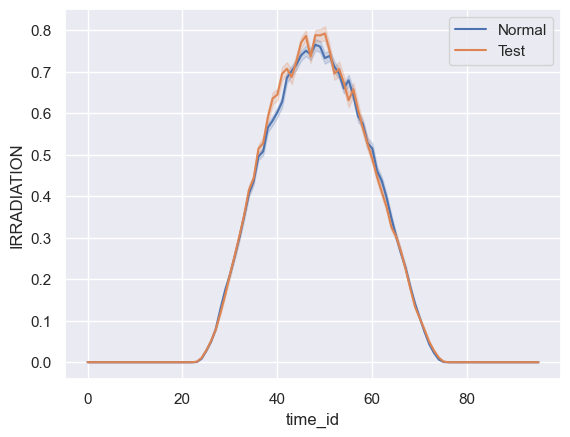

In [20]:
import seaborn as sns

# sns.lineplot(x=X['time_id'], y=y, label='Normal')
# sns.lineplot(x=X_test['time_id'], y=y_test, label='Test')

sns.lineplot(x=X['time_id'], y=X['IRRADIATION'], label='Normal')
sns.lineplot(x=X_test['time_id'], y=X_test['IRRADIATION'], label='Test')

In [17]:
# Train Stage
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import numpy as np 
from sklearn.pipeline import  make_pipeline

param_dist = {
    "polynomialfeatures__degree":np.arange(1, 15, 1)
}
model = make_pipeline(PolynomialFeatures(), LinearRegression())
search = GridSearchCV(model, param_grid=param_dist, cv=2, n_jobs=-1)
search.fit(x_train, y_train)
modelGB = lgb.LGBMRegressor()
modelGB.fit(x_train, y_train)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 71269, number of used features: 4
[LightGBM] [Info] Start training from score 293.022549


LGBMRegressor()

Same as for filling the datasets the lightGBM model is more suitable.

UPDATE 1: 
With some tuning and putting the linear regression through a Polynomial feature pipeline, can achieve a close metrics than non-tuned LightGBM.
But on the residuals part, there's more data that are far for each others but the repartition of those residuals is grouped compared to one's for LightGBM which is more eratic.  


0.9838310999217718
19.296158069433158
2462.4540636675465
49.62312025324029
0.23114248037763363
190.19356392010513
288610.05014806474
537.2243945950935
0.5841214858793062
81.93844971980981
65336.229087676336
255.6095246419357


<Axes: xlabel='time_id', ylabel='AC_POWER'>

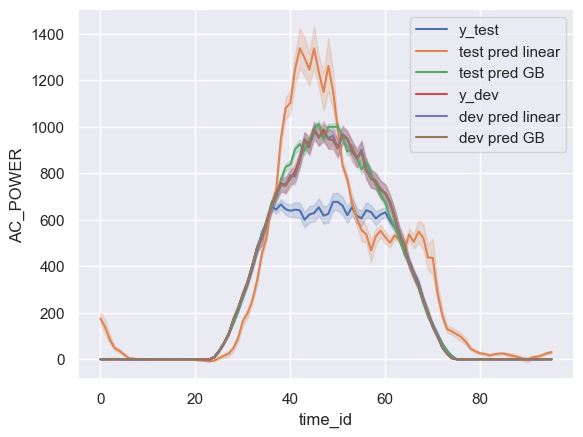

In [13]:
# Testing

from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

preds = search.predict(x_dev)
predsGB = modelGB.predict(x_dev)
print(r2_score(preds, y_dev))
print(mean_absolute_error(preds, y_dev))
print(mean_squared_error(preds, y_dev, squared=True))
print(mean_squared_error(preds, y_dev, squared=False))

predst = search.predict(X_test)
predstGB = modelGB.predict(X_test)
print(r2_score(predst, y_test))
print(mean_absolute_error(predst, y_test))
print(mean_squared_error(predst, y_test, squared=True))
print(mean_squared_error(predst, y_test, squared=False))
print(r2_score(predstGB, y_test))
print(mean_absolute_error(predstGB, y_test))
print(mean_squared_error(predstGB, y_test, squared=True))
print(mean_squared_error(predstGB, y_test, squared=False))

import seaborn as sns
sns.set_theme()
sns.lineplot(x=X_test['time_id'], y=y_test, label='y_test')
sns.lineplot(x=X_test['time_id'], y=predst, label='test pred linear')
sns.lineplot(x=X_test['time_id'], y=predstGB, label='test pred GB')
sns.lineplot(x=x_dev['time_id'], y=y_dev, label='y_dev')
sns.lineplot(x=x_dev['time_id'], y=preds, label='dev pred linear')
sns.lineplot(x=x_dev['time_id'], y=predsGB, label='dev pred GB')


0.9823999198060136
19.173619302275988
2671.961085568822
51.69101552077326

<Axes: xlabel='AC_POWER', ylabel='AC_POWER'>

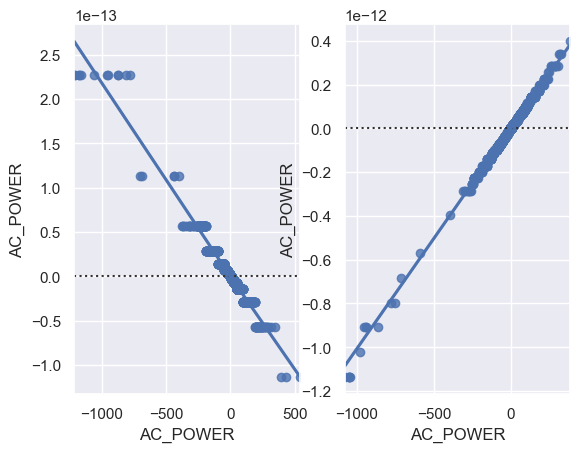

<Figure size 600x600 with 0 Axes>

In [51]:
# Plotting 

import seaborn as sns 
import matplotlib.pyplot as plt

residuals = y_dev - preds
residualsGB = y_dev - predsGB

plt.show()

fig , axes = plt.subplots(nrows=1, ncols=2)
sns.set_theme()
plt.figure(figsize=(6,6))
sns.residplot(x=residuals, y=residuals, lowess=True, ax=axes[0])
# plt.xlabel("Fitted Values")
# plt.ylabel("Residuals")
# plt.title("Residuals Plot Linear")
# sns.set_theme()
# plt.figure(figsize=(6,6))
sns.residplot(x=residualsGB, y=residualsGB, lowess=True, ax=axes[1])
# plt.xlabel("Fitted Values")
# plt.ylabel("Residuals")
# plt.title("Residuals Plot GB")

In [35]:
# What about test set



-0.16823924958369485
8018.925228270073
163818181.6057019
12799.147690596506
0.5857713368494162
81.67050513071572
65826.56867974719
256.5668892896104


<Axes: xlabel='time_id', ylabel='AC_POWER'>

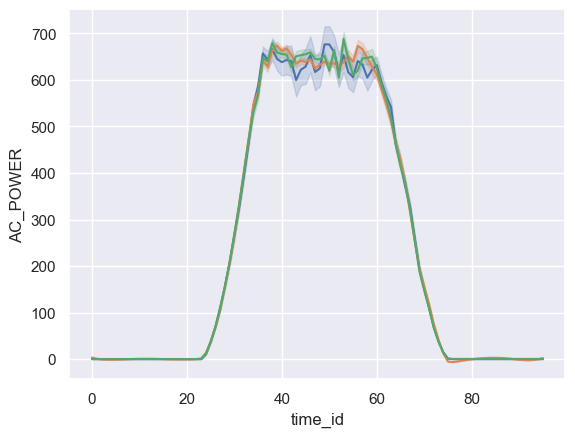

Remark: After getting pretty good metrics on train and dev sets, the metrics outputed by the test sets are awfully bad. We can even observe that in this case, the linear regression model is slightly better than LighGBM.

We can also observe that the slope is still well fitted until roughly 30~ as time_id, which look like the big point of problem.

How to solve? The main reason I see there is that we have 2 differents sets which is impacting the overall accuracy.

This could explain the start and end of the slope being well fitted, but the middle isn't.
Let's try adding some clustering on the sets to observe any differences. --> This doesn't help 

UPDATE 1: By changing variables' names, Linear model is getting out of hands and his metrics are extremely wrong (Maybe need to reload notebook)

UPDATE 2: After multiple checks and display of both training/dev and testing sets' slopes.
We can affirm that the difference of AC_POWER is too big and that even by taking all the columns of sensor's dataset (which train and test slopes are roughly similar) the train/test slope of AC_POWER are just too different, multiple reasons can be exposed but with the difference between both plants, we'll not be able to fit on plant 1 and test on plant 2


UPDATE 2 bis:

As we want to predict outputed ac power from a given time and additionally more infos like irradiation and/or all columns from sensor datasets.
With all infos from the sensors, the outputed power (AC or DC) is significantly lower on plant 2.
With the current data, I believe we cannot predict AC or DC output from all other data.

